In [ ]:
!nvidia-smi

Mon Sep  6 14:52:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from PIL import Image
from torchvision import models
from torch import optim  # For optimizers like SGD, Adam, etc.
# import torch_optimizer as optimi
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torchsummary import summary
import numpy as np
import pandas as pd
import os
import skimage as io
import torch.backends.cudnn as cudnn
import torch.nn.init as init
from torch.autograd import Variable
import sys
import time

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_uniform_(m.weight, mode='fan_out')
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )
    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = F.celu(self.bn1(out), alpha=0.075)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [ ]:
# Hyperparameters
num_classes = 10
learning_rate = 0.01
batch_size = 128
num_epochs = 200

In [ ]:
model = Wide_ResNet(28, 10, 0.3, 10)
model.apply(conv_init)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
# print(model)

| Wide-Resnet 28x10


In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3          [-1, 160, 32, 32]          23,200
           Dropout-4          [-1, 160, 32, 32]               0
       BatchNorm2d-5          [-1, 160, 32, 32]             320
            Conv2d-6          [-1, 160, 32, 32]         230,560
            Conv2d-7          [-1, 160, 32, 32]           2,720
        wide_basic-8          [-1, 160, 32, 32]               0
       BatchNorm2d-9          [-1, 160, 32, 32]             320
           Conv2d-10          [-1, 160, 32, 32]         230,560
          Dropout-11          [-1, 160, 32, 32]               0
      BatchNorm2d-12          [-1, 160, 32, 32]             320
           Conv2d-13          [-1, 160, 32, 32]         230,560
       wide_basic-14          [-1, 160,

In [ ]:
# Load Data
transform_train = transforms.Compose(
    [  # Compose makes it possible to have many transforms
        # transforms.ToPILImage(),
        transforms.Resize((40, 40)),  # Resizes (32,32) to (36,36)
        transforms.RandomCrop(32, padding=4),  # Takes a random (32,32) crop
        transforms.ColorJitter(brightness=0.5),  # Change brightness of image
        transforms.RandomRotation(
           degrees=55
        ),  # Perhaps a random rotation from -45 to 45 degrees
        # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        transforms.RandomHorizontalFlip(
          #  p=0.5
        ),  # Flips the image horizontally with probability 0.5
        transforms.RandomVerticalFlip(
            p=0.05
        ),  # Flips image vertically with probability 0.05
        transforms.RandomGrayscale(p=0.2),  # Converts to grayscale with probability 0.2
        transforms.ToTensor(),  # Finally converts PIL image to tensor so we can train w. pytorch
        # transforms.Normalize((0.4850, 0.4560, 0.4060), (0.2290, 0.2240, 0.2250)),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        # Note: these values aren't optimal / (value -mean)/std
    ]
)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4850, 0.4560, 0.4060), (0.2290, 0.2240, 0.2250)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_TTA = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(
           degrees=45
    ),  # Perhaps a random rotation from -45 to 45 degrees
    # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.RandomHorizontalFlip(
      #  p=0.5
    ),  # Flips the image horizontally with probability 0.5
    transforms.RandomVerticalFlip(
        p=0.05
    ),  # Flips image vertically with probability 0.05
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_dataset = datasets.CIFAR10(root="/content/drive/MyDrive/COLAB/Learn Pytorch/data", train=True, transform=transform_train, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)
test_dataset = datasets.CIFAR10(root="/content/drive/MyDrive/COLAB/Learn Pytorch/data", train=False, transform=transform_test, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False, num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def get_mask(rate):
    image_shape = 32
    box_size = int(np.sqrt(1. - rate) * image_shape)
    x = np.random.randint(0, image_shape - box_size + 1)
    mask = torch.ones((3, image_shape, image_shape)).to(device)
    mask[:, x:(x+box_size), x:(x+box_size)] = 0
    return mask
def cutmix(x, y):
    alpha = 1.0
    lam = np.random.beta(alpha, alpha)

    index = torch.randperm(x.size()[0]).cuda()
    mask = get_mask(lam)

    mixed_x = x.mul(mask) + x[index, :].mul(1. - mask)
    mixed_y = y * lam + y[index, :] * (1 - lam)
    return mixed_x, mixed_y
def cutout(x, y):
    # alpha = 1.0
    # lam = np.random.beta(alpha, alpha)
    lam = np.random.uniform(low=0.75, high=0.96, size=None)

    mask = get_mask(lam)

    mixed_x = x.mul(mask)
    mixed_y = y * lam
    return mixed_x, mixed_y
def mixup(x, y):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    alpha = 1.0
    lam = np.random.beta(alpha, alpha)

    index = torch.randperm(x.size()[0]).cuda()

    mixed_x = x * lam + x[index, :] * (1 - lam)
    mixed_y = y * lam + y[index, :] * (1 - lam)
    return mixed_x, mixed_y
def Augmentation(inputs, targets):
    targets = 1.0 * F.one_hot(targets, num_classes=num_classes).float()
    flag = np.random.randint(2)
    if flag == 0: inputs, targets = mixup(inputs, targets)
    elif flag == 1: inputs, targets = cutmix(inputs, targets)
    else : inputs, targets = cutout(inputs, targets)
    # if flag == 0: inputs, targets = mixup(inputs, targets)
    return inputs, targets

In [ ]:
#Loss and Optimizer
class SmoothCrossEntropy(nn.Module):
    def __init__(self, alpha=0.2):
        super(SmoothCrossEntropy, self).__init__()
        self.alpha = alpha

    def forward(self, logits, labels):
        num_classes = logits.shape[-1]
        alpha_div_k = self.alpha / num_classes
        target_probs = 1.0 * labels * \
            (1. - self.alpha) + alpha_div_k
        loss = -(target_probs * torch.log_softmax(logits, dim=-1)).sum(dim=-1)
        return loss.mean()
criterion = nn.CrossEntropyLoss()
criterion_train = SmoothCrossEntropy()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.95, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, verbose = True)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4,
#                                                 total_steps=50 * 391, epochs=50, steps_per_epoch=391, pct_start=0.3, anneal_strategy='cos', 
#                                                 cycle_momentum=True, base_momentum=0.8, max_momentum=0.95, 
#                                                 div_factor=25.0, final_div_factor=10000.0, three_phase=False, last_epoch=-1, 
#                                                 verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
# Load checkpoint
print('| Resuming from checkpoint...')
checkpoint = torch.load( '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
model.load_state_dict(checkpoint['model'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

| Resuming from checkpoint...


In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Augmentation(inputs, targets)
        
        #forawrd 
        outputs = model(inputs)
        loss = criterion_train(outputs, targets)
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        # total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()
        _, truth = targets.max(1)
        total += targets.size(0)
        correct += predicted.eq(truth).sum().item()

        #backward
        optimizer.zero_grad()
        loss.backward()
        #gradient descent and adam step
        optimizer.step()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()
    print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):

            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            sys.stdout.write('\r')
            sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.4f%%'
                %(epoch, num_epochs, batch_idx + 1,
                    (len(test_dataset)//100), loss.item(), 100.*correct/total))
            sys.stdout.flush()
        print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

    # Save checkpoint.
        acc = 100.*correct/total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.4f%%" %(epoch, loss.item(), acc))
        if acc > best_acc:
            print('Saving..')
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
            best_acc = acc

for epoch in range(start_epoch, start_epoch+100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 206
| Epoch [206/200] Iter[391/391]		Loss: 0.9862 Acc@1: 86.728%
Loss: 1.26412  Accuracy: 86.72800%
| Epoch [206/200] Iter[100/ 78]		Loss: 0.3830 Acc@1: 96.2700%
Loss: 0.39201  Accuracy: 96.27000%

| Validation Epoch #206			Loss: 0.3830 Acc@1: 96.2700%
Adjusting learning rate of group 0 to 1.0365e-03.

Epoch: 207
| Epoch [207/200] Iter[391/391]		Loss: 0.9707 Acc@1: 86.934%
Loss: 1.25917  Accuracy: 86.93400%
| Epoch [207/200] Iter[100/ 78]		Loss: 0.4341 Acc@1: 96.4200%
Loss: 0.44442  Accuracy: 96.42000%

| Validation Epoch #207			Loss: 0.4341 Acc@1: 96.4200%
Saving..
Adjusting learning rate of group 0 to 9.2835e-04.

Epoch: 208
| Epoch [208/200] Iter[391/391]		Loss: 0.9830 Acc@1: 86.206%
Loss: 1.26946  Accuracy: 86.20600%
| Epoch [208/200] Iter[100/ 78]		Loss: 0.4475 Acc@1: 96.0500%
Loss: 0.45241  Accuracy: 96.05000%

| Validation Epoch #208			Loss: 0.4475 Acc@1: 96.0500%
Adjusting learning rate of group 0 to 8.2443e-04.

Epoch: 209
| Epoch [209/200] Iter[391/391]		Loss: 1.0112 

KeyboardInterrupt: ignored

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Augmentation(inputs, targets)
        
        #forawrd 
        outputs = model(inputs)
        loss = criterion_train(outputs, targets)
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        # total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()
        _, truth = targets.max(1)
        total += targets.size(0)
        correct += predicted.eq(truth).sum().item()

        #backward
        optimizer.zero_grad()
        loss.backward()
        #gradient descent and adam step
        optimizer.step()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()
    print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):

            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            sys.stdout.write('\r')
            sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.4f%%'
                %(epoch, num_epochs, batch_idx + 1,
                    (len(test_dataset)//batch_size), loss.item(), 100.*correct/total))
            sys.stdout.flush()
        print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

    # Save checkpoint.
        acc = 100.*correct/total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.4f%%" %(epoch, loss.item(), acc))
        if acc > best_acc:
            print('Saving..')
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
            best_acc = acc

for epoch in range(start_epoch, start_epoch+100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 175
| Epoch [175/200] Iter[391/391]		Loss: 1.0536 Acc@1: 82.437%
Loss: 1.34680  Accuracy: 82.43686%
| Epoch [175/200] Iter[ 99/ 78]		Loss: 0.3563 Acc@1: 92.9100%
Loss: 0.35937  Accuracy: 92.91000%

| Validation Epoch #175			Loss: 0.3563 Acc@1: 92.9100%
Adjusting learning rate of group 0 to 3.9961e-03.

Epoch: 176
| Epoch [176/200] Iter[391/391]		Loss: 1.0300 Acc@1: 83.832%
Loss: 1.31037  Accuracy: 83.83200%
| Epoch [176/200] Iter[ 99/ 78]		Loss: 0.3602 Acc@1: 93.0300%
Loss: 0.36612  Accuracy: 93.03000%

| Validation Epoch #176			Loss: 0.3602 Acc@1: 93.0300%
Adjusting learning rate of group 0 to 3.9842e-03.

Epoch: 177
| Epoch [177/200] Iter[391/391]		Loss: 1.0383 Acc@1: 82.245%
Loss: 1.33000  Accuracy: 82.24504%
| Epoch [177/200] Iter[ 99/ 78]		Loss: 0.3443 Acc@1: 92.7100%
Loss: 0.32779  Accuracy: 92.71000%

| Validation Epoch #177			Loss: 0.3443 Acc@1: 92.7100%
Adjusting learning rate of group 0 to 3.9646e-03.

Epoch: 178
| Epoch [178/200] Iter[391/391]		Loss: 1.1163 Acc@1: 83

KeyboardInterrupt: ignored

In [35]:
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss on testing data: %.4f Accuracy on testing data: %.4f%%'
            %(230, 230, batch_idx+1,
                (len(test_dataset)//100), loss.item(), 100.*correct/total))
        sys.stdout.flush()
    print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

| Epoch [230/230] Iter[100/100]		Loss on testing data: 0.3858 Accuracy on testing data: 96.6800%
Loss: 0.38371  Accuracy: 96.68000%


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

test_predictions = torch.tensor([]).cuda()
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        inputs, targets = inputs.cuda(), targets.cuda()
        # inputs, targets = Variable(inputs), Variable(targets)
        outputs = model(inputs)
        test_predictions = torch.cat((test_predictions, outputs), dim = 0)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        # sys.stdout.write('\r')
        # sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.4f%%'
        #     %(epoch, num_epochs, batch_idx+1,
        #         (len(test_dataset)//100), loss.item(), 100.*correct/total))
        # sys.stdout.flush()
    print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


Loss: 0.38371  Accuracy: 96.68000%


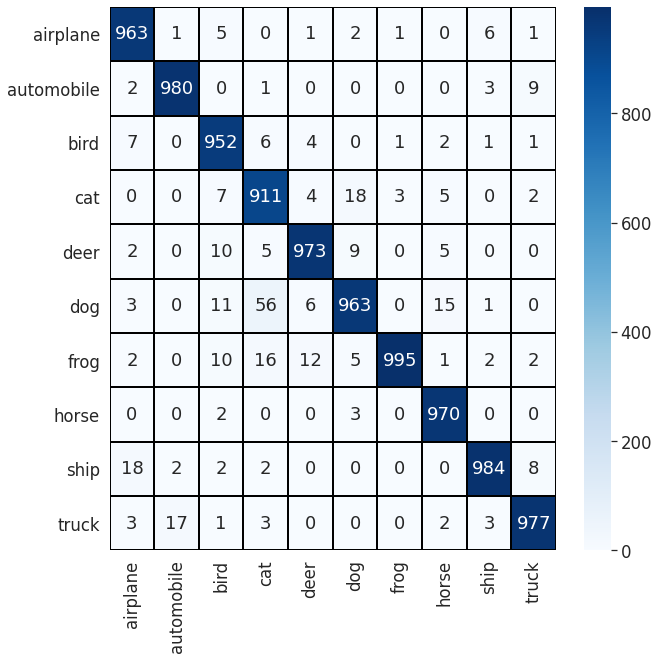

In [ ]:
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.set(font_scale=1.5)
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

[[963   1   5   0   1   2   1   0   6   1]
 [  2 980   0   1   0   0   0   0   3   9]
 [  7   0 952   6   4   0   1   2   1   1]
 [  0   0   7 911   4  18   3   5   0   2]
 [  2   0  10   5 973   9   0   5   0   0]
 [  3   0  11  56   6 963   0  15   1   0]
 [  2   0  10  16  12   5 995   1   2   2]
 [  0   0   2   0   0   3   0 970   0   0]
 [ 18   2   2   2   0   0   0   0 984   8]
 [  3  17   1   3   0   0   0   2   3 977]]


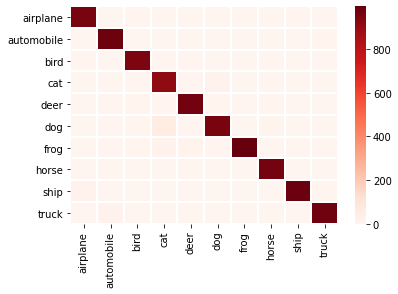

In [ ]:
import seaborn as sns
# for i in range(10): class_names.append(str(i))
cm = confusion_matrix(test_predictions.argmax(dim=1).cpu(), torch.Tensor(test_dataset.targets))
print(cm)
ax = sns.heatmap(cm, 
                 cmap = 'Reds', 
                 linewidth = 1,xticklabels = test_dataset.classes, yticklabels = test_dataset.classes)

In [ ]:
test_dataset_TTA = datasets.CIFAR10(root="/content/drive/MyDrive/COLAB/Learn Pytorch/data", train=False, transform=transform_TTA, download=True)
TTA_loader = DataLoader(dataset=test_dataset_TTA, batch_size=100, shuffle=False, num_workers = 2)

Files already downloaded and verified


In [ ]:
predictions = torch.zeros((100, 100, 10)).cuda()
for _ in tqdm(range(1000)):
    model.eval()
    with torch.no_grad():
    # predictions = np.zeros((len(test_dataset_TTA) // 100, 100))
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)  
            # print(outputs.shape)
            # _, predicted = outputs.max(1)
            # outputs = F.softmax(outputs)
            # print(outputs)
            # break
            _, predicted = outputs.max(1)
            one_hot = F.one_hot(predicted, num_classes=num_classes)
            predictions[batch_idx] += one_hot
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        TTA = torch.argmax(predictions[batch_idx], dim=1)
        total += targets.size(0)
        correct += TTA.eq(targets).sum().item()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.4f%%'
            %(1, num_epochs, batch_idx+1,
                (len(test_dataset)//100), loss.item(), 100.*correct/total))
        sys.stdout.flush()
            # print(len(predicted))
            # for i in range(len(predicted)):
            #     predictions[batch_idx][i][predicted[i]] += 1
    

  0%|          | 0/1000 [00:00<?, ?it/s]

| Epoch [  1/200] Iter[100/100]		Loss: 0.3858 Acc@1: 96.6800%

  0%|          | 1/1000 [00:11<3:14:09, 11.66s/it]

| Epoch [  1/200] Iter[100/100]		Loss: 0.3858 Acc@1: 96.6800%

  0%|          | 2/1000 [00:23<3:13:37, 11.64s/it]

| Epoch [  1/200] Iter[100/100]		Loss: 0.3858 Acc@1: 96.6800%

  0%|          | 3/1000 [00:34<3:13:54, 11.67s/it]

| Epoch [  1/200] Iter[100/100]		Loss: 0.3858 Acc@1: 96.6800%

  0%|          | 4/1000 [00:53<3:42:40, 13.41s/it]


KeyboardInterrupt: ignored

In [ ]:
for batch_idx, (inputs, targets) in enumerate(TTA_loader):
    print(predictions[batch_idx])

Streaming output truncated to the last 5000 lines.
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],

In [ ]:
for batch_idx, (inputs, targets) in enumerate(TTA_loader):
    print(torch.argmax(predictions[batch_idx], dim=1)

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 0,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 5, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7])
tensor([4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 6, 7, 8, 3, 1, 2,
        8, 0, 8, 3, 3, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 5,
        5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 0, 2, 8, 4, 5, 0, 9, 9,
        9, 8, 9, 9, 3, 7, 3, 0, 0, 5, 2, 2, 3, 8, 6, 3, 3, 0, 5, 8, 0, 1, 7, 2,
        8, 8, 7, 8])
tensor([5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4,
        3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9,
        2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 8, 8, 2, 4, 7, 0, 2, 3,
        6, 5, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Augmentation(inputs, targets)
        # print(batch_idx)
        #forawrd 
        outputs = model(inputs)
        loss = criterion_train(outputs, targets)
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        # total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()
        _, truth = targets.max(1)
        total += targets.size(0)
        correct += predicted.eq(truth).sum().item()

        #backward
        optimizer.zero_grad()
        loss.backward()
        #gradient descent and adam step
        optimizer.step()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()
    print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):

            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            sys.stdout.write('\r')
            sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.4f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(test_dataset)//100), loss.item(), 100.*correct/total))
            sys.stdout.flush()
        print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

    # Save checkpoint.
        acc = 100.*correct/total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.4f%%" %(epoch, loss.item(), acc))
        if acc > best_acc:
            print('Saving..')
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
            best_acc = acc

for epoch in range(start_epoch, start_epoch+100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 144
| Epoch [144/200] Iter[391/391]		Loss: 0.1768 Acc@1: 83.048%
Loss: 0.81173  Accuracy: 83.04800%
| Epoch [144/200] Iter[100/100]		Loss: 0.2246 Acc@1: 94.1900%
Loss: 0.22666  Accuracy: 94.19000%

| Validation Epoch #144			Loss: 0.2246 Acc@1: 94.1900%
Adjusting learning rate of group 0 to 1.9945e-04.

Epoch: 145
| Epoch [145/200] Iter[391/391]		Loss: 0.5698 Acc@1: 83.426%
Loss: 0.77679  Accuracy: 83.42600%
| Epoch [145/200] Iter[100/100]		Loss: 0.1942 Acc@1: 93.9600%
Loss: 0.21258  Accuracy: 93.96000%

| Validation Epoch #145			Loss: 0.1942 Acc@1: 93.9600%
Adjusting learning rate of group 0 to 1.9781e-04.

Epoch: 146
| Epoch [146/200] Iter[391/391]		Loss: 0.2799 Acc@1: 84.138%
Loss: 0.78610  Accuracy: 84.13800%
| Epoch [146/200] Iter[100/100]		Loss: 0.2310 Acc@1: 94.0800%
Loss: 0.21874  Accuracy: 94.08000%

| Validation Epoch #146			Loss: 0.2310 Acc@1: 94.0800%
Adjusting learning rate of group 0 to 1.9511e-04.

Epoch: 147
| Epoch [147/200] Iter[391/391]		Loss: 0.1832 Acc@1: 82

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Augmentation(inputs, targets)
        # print(batch_idx)
        #forawrd 
        outputs = model(inputs)
        loss = criterion_train(outputs, targets)
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        # total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()
        _, truth = targets.max(1)
        total += targets.size(0)
        correct += predicted.eq(truth).sum().item()

        #backward
        optimizer.zero_grad()
        loss.backward()
        #gradient descent and adam step
        optimizer.step()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()
    print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):

            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            sys.stdout.write('\r')
            sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.4f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(test_dataset)//100), loss.item(), 100.*correct/total))
            sys.stdout.flush()
        print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

    # Save checkpoint.
        acc = 100.*correct/total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.4f%%" %(epoch, loss.item(), acc))
        if acc > best_acc:
            print('Saving..')
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
            best_acc = acc

for epoch in range(start_epoch, start_epoch+100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 115
| Epoch [115/200] Iter[391/391]		Loss: 0.7279 Acc@1: 79.992%
Loss: 1.10780  Accuracy: 79.99200%
| Epoch [115/200] Iter[100/100]		Loss: 0.3219 Acc@1: 93.0900%
Loss: 0.30655  Accuracy: 93.09000%

| Validation Epoch #115			Loss: 0.3219 Acc@1: 93.0900%
Adjusting learning rate of group 0 to 9.9726e-04.

Epoch: 116
| Epoch [116/200] Iter[391/391]		Loss: 0.8622 Acc@1: 77.324%
Loss: 1.14793  Accuracy: 77.32400%
| Epoch [116/200] Iter[100/100]		Loss: 0.3032 Acc@1: 93.1600%
Loss: 0.29075  Accuracy: 93.16000%

| Validation Epoch #116			Loss: 0.3032 Acc@1: 93.1600%
Adjusting learning rate of group 0 to 9.8907e-04.

Epoch: 117
| Epoch [117/200] Iter[391/391]		Loss: 0.4098 Acc@1: 78.130%
Loss: 1.13470  Accuracy: 78.13000%
| Epoch [117/200] Iter[100/100]		Loss: 0.2635 Acc@1: 93.5000%
Loss: 0.26346  Accuracy: 93.50000%

| Validation Epoch #117			Loss: 0.2635 Acc@1: 93.5000%
Adjusting learning rate of group 0 to 9.7553e-04.

Epoch: 118
| Epoch [118/200] Iter[391/391]		Loss: 0.1622 Acc@1: 77

In [ ]:
  # Training
  def train(epoch):
      print('\nEpoch: %d' % epoch)
      model.train()
      train_loss = 0
      correct = 0
      total = 0
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          inputs, targets = inputs.cuda(), targets.cuda()
          inputs, targets = Augmentation(inputs, targets)
          # print(batch_idx)
          #forawrd 
          outputs = model(inputs)
          loss = criterion_train(outputs, targets)
          
          train_loss += loss.item()
          _, predicted = outputs.max(1)
          # total += targets.size(0)
          # correct += predicted.eq(targets).sum().item()
          _, truth = targets.max(1)
          total += targets.size(0)
          correct += predicted.eq(truth).sum().item()

          #backward
          optimizer.zero_grad()
          loss.backward()
          #gradient descent and adam step
          optimizer.step()
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
          sys.stdout.flush()
      print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


  def test(epoch):
      global best_acc
      model.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(test_loader):

              inputs, targets = inputs.cuda(), targets.cuda()
              outputs = model(inputs)
              loss = criterion(outputs, targets)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
              sys.stdout.write('\r')
              sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.4f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(test_dataset)//100), loss.item(), 100.*correct/total))
              sys.stdout.flush()
          print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

      # Save checkpoint.
          acc = 100.*correct/total
          print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.4f%%" %(epoch, loss.item(), acc))
          if acc > best_acc:
              print('Saving..')
              state = {
                  'model': model.state_dict(),
                  'acc': acc,
                  'epoch': epoch,
              }
              if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
              torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
              best_acc = acc

  for epoch in range(start_epoch, start_epoch+100):
      train(epoch)
      test(epoch)
      scheduler.step()


Epoch: 90
| Epoch [ 90/200] Iter[261/261]		Loss: 0.6478 Acc@1: 88.652%
Loss: 0.95604  Accuracy: 88.65200%
| Epoch [ 90/200] Iter[100/ 53]		Loss: 0.2599 Acc@1: 93.5000%
Loss: 0.27379  Accuracy: 93.50000%

| Validation Epoch #90			Loss: 0.2599 Acc@1: 93.5000%
Adjusting learning rate of group 0 to 1.9945e-03.

Epoch: 91
| Epoch [ 91/200] Iter[261/261]		Loss: 0.8350 Acc@1: 86.896%
Loss: 1.02505  Accuracy: 86.89600%
| Epoch [ 91/200] Iter[100/ 53]		Loss: 0.2600 Acc@1: 93.7000%
Loss: 0.27316  Accuracy: 93.70000%

| Validation Epoch #91			Loss: 0.2600 Acc@1: 93.7000%
Adjusting learning rate of group 0 to 1.9781e-03.

Epoch: 92
| Epoch [ 92/200] Iter[261/261]		Loss: 0.6863 Acc@1: 86.484%
Loss: 1.01395  Accuracy: 86.48400%
| Epoch [ 92/200] Iter[100/ 53]		Loss: 0.2673 Acc@1: 93.4500%
Loss: 0.24760  Accuracy: 93.45000%

| Validation Epoch #92			Loss: 0.2673 Acc@1: 93.4500%
Adjusting learning rate of group 0 to 1.9511e-03.

Epoch: 93
| Epoch [ 93/200] Iter[261/261]		Loss: 0.8322 Acc@1: 87.112%
L

In [ ]:
  # Training
  def train(epoch):
      print('\nEpoch: %d' % epoch)
      model.train()
      train_loss = 0
      correct = 0
      total = 0
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          inputs, targets = inputs.cuda(), targets.cuda()
          inputs, targets = Augmentation(inputs, targets)
          # print(batch_idx)
          #forawrd 
          outputs = model(inputs)
          loss = criterion_train(outputs, targets)
          
          train_loss += loss.item()
          _, predicted = outputs.max(1)
          # total += targets.size(0)
          # correct += predicted.eq(targets).sum().item()
          _, truth = targets.max(1)
          total += targets.size(0)
          correct += predicted.eq(truth).sum().item()

          #backward
          optimizer.zero_grad()
          loss.backward()
          #gradient descent and adam step
          optimizer.step()
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
          sys.stdout.flush()
      print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


  def test(epoch):
      global best_acc
      model.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(test_loader):

              inputs, targets = inputs.cuda(), targets.cuda()
              outputs = model(inputs)
              loss = criterion(outputs, targets)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
              sys.stdout.write('\r')
              sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.4f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(test_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
              sys.stdout.flush()
          print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

      # Save checkpoint.
          acc = 100.*correct/total
          print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.4f%%" %(epoch, loss.item(), acc))
          if acc > best_acc:
              print('Saving..')
              state = {
                  'model': model.state_dict(),
                  'acc': acc,
                  'epoch': epoch,
              }
              if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
              torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
              best_acc = acc

  for epoch in range(start_epoch, start_epoch+100):
      train(epoch)
      test(epoch)
      scheduler.step()


Epoch: 85
| Epoch [ 85/200] Iter[196/196]		Loss: 0.6423 Acc@1: 90.146%
Loss: 0.88561  Accuracy: 90.14600%
| Epoch [ 85/200] Iter[100/ 40]		Loss: 0.2146 Acc@1: 93.910%
Loss: 0.22092  Accuracy: 93.91000%

| Validation Epoch #85			Loss: 0.2146 Acc@1: 93.91%
Adjusting learning rate of group 0 to 9.9901e-04.

Epoch: 86
| Epoch [ 86/200] Iter[196/196]		Loss: 0.6530 Acc@1: 90.714%
Loss: 0.86368  Accuracy: 90.71400%
| Epoch [ 86/200] Iter[100/ 40]		Loss: 0.2125 Acc@1: 94.130%
Loss: 0.21815  Accuracy: 94.13000%

| Validation Epoch #86			Loss: 0.2125 Acc@1: 94.13%
Adjusting learning rate of group 0 to 9.9606e-04.

Epoch: 87
| Epoch [ 87/200] Iter[196/196]		Loss: 0.6308 Acc@1: 90.634%
Loss: 0.88867  Accuracy: 90.63400%
| Epoch [ 87/200] Iter[100/ 40]		Loss: 0.2325 Acc@1: 94.200%
Loss: 0.24215  Accuracy: 94.20000%

| Validation Epoch #87			Loss: 0.2325 Acc@1: 94.20%
Saving..
Adjusting learning rate of group 0 to 9.9114e-04.

Epoch: 88
| Epoch [ 88/200] Iter[196/196]		Loss: 0.6565 Acc@1: 90.224%
L

KeyboardInterrupt: ignored

In [ ]:
  # Training
  def train(epoch):
      print('\nEpoch: %d' % epoch)
      model.train()
      train_loss = 0
      correct = 0
      total = 0
      optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
      
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          inputs, targets = inputs.cuda(), targets.cuda()
          inputs, targets = Augmentation(inputs, targets)
          # print(batch_idx)
          #forawrd 
          outputs = model(inputs)
          loss = criterion_train(outputs, targets)
          
          train_loss += loss.item()
          _, predicted = outputs.max(1)
          # total += targets.size(0)
          # correct += predicted.eq(targets).sum().item()
          _, truth = targets.max(1)
          total += targets.size(0)
          correct += predicted.eq(truth).sum().item()

          #backward
          optimizer.zero_grad()
          loss.backward()
          #gradient descent and adam step
          optimizer.step()
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
          sys.stdout.flush()
      print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


  def test(epoch):
      global best_acc
      model.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(test_loader):

              inputs, targets = inputs.cuda(), targets.cuda()
              outputs = model(inputs)
              loss = criterion(outputs, targets)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
              sys.stdout.write('\r')
              sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(test_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
              sys.stdout.flush()
          print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

      # Save checkpoint.
          acc = 100.*correct/total
          print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))
          if acc > best_acc:
              print('Saving..')
              state = {
                  'model': model.state_dict(),
                  'acc': acc,
                  'epoch': epoch,
              }
              if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
              torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
              best_acc = acc

  for epoch in range(start_epoch, start_epoch+50):
      train(epoch)
      test(epoch)
      # scheduler.step()


Epoch: 85

=> Training Epoch #85, LR=0.0050
| Epoch [ 85/200] Iter[196/196]		Loss: 1.0609 Acc@1: 82.896%
Loss: 1.15646  Accuracy: 82.89600%
| Epoch [ 85/200] Iter[100/ 40]		Loss: 0.2369 Acc@1: 93.460%
Loss: 0.26651  Accuracy: 93.46000%

| Validation Epoch #85			Loss: 0.2369 Acc@1: 93.46%

Epoch: 86

=> Training Epoch #86, LR=0.0050
| Epoch [ 86/200] Iter[196/196]		Loss: 1.0975 Acc@1: 83.366%
Loss: 1.11738  Accuracy: 83.36600%
| Epoch [ 86/200] Iter[100/ 40]		Loss: 0.2584 Acc@1: 93.510%
Loss: 0.28048  Accuracy: 93.51000%

| Validation Epoch #86			Loss: 0.2584 Acc@1: 93.51%

Epoch: 87

=> Training Epoch #87, LR=0.0050
| Epoch [ 87/200] Iter[196/196]		Loss: 1.7644 Acc@1: 84.444%
Loss: 1.09034  Accuracy: 84.44400%
| Epoch [ 87/200] Iter[100/ 40]		Loss: 0.2420 Acc@1: 92.680%
Loss: 0.25402  Accuracy: 92.68000%

| Validation Epoch #87			Loss: 0.2420 Acc@1: 92.68%

Epoch: 88

=> Training Epoch #88, LR=0.0050
| Epoch [ 88/200] Iter[196/196]		Loss: 0.6848 Acc@1: 82.602%
Loss: 1.09099  Accuracy:

KeyboardInterrupt: ignored

In [ ]:
  # Training
  def train(epoch):
      print('\nEpoch: %d' % epoch)
      model.train()
      train_loss = 0
      correct = 0
      total = 0
      optimizer = optim.SGD(model.parameters(), lr=2e-4, momentum=0.9, weight_decay=1e-4)
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          inputs, targets = inputs.cuda(), targets.cuda()
          inputs, targets = Augmentation(inputs, targets)
          # print(batch_idx)
          #forawrd 
          outputs = model(inputs)
          loss = criterion_train(outputs, targets)
          
          train_loss += loss.item()
          _, predicted = outputs.max(1)
          # total += targets.size(0)
          # correct += predicted.eq(targets).sum().item()
          _, truth = targets.max(1)
          total += targets.size(0)
          correct += predicted.eq(truth).sum().item()

          #backward
          optimizer.zero_grad()
          loss.backward()
          #gradient descent and adam step
          optimizer.step()
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
          sys.stdout.flush()
      print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


  def test(epoch):
      global best_acc
      model.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(test_loader):

              inputs, targets = inputs.cuda(), targets.cuda()
              outputs = model(inputs)
              loss = criterion(outputs, targets)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
              sys.stdout.write('\r')
              sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(test_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
              sys.stdout.flush()
          print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

      # Save checkpoint.
          acc = 100.*correct/total
          print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))
          if acc > best_acc:
              print('Saving..')
              state = {
                  'model': model.state_dict(),
                  'acc': acc,
                  'epoch': epoch,
              }
              if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
              torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
              best_acc = acc

  for epoch in range(start_epoch, start_epoch+50):
      train(epoch)
      test(epoch)
      # scheduler.step()


Epoch: 72

=> Training Epoch #72, LR=0.0008
| Epoch [ 72/200] Iter[391/391]		Loss: 0.6971 Acc@1: 87.122%
Loss: 1.18375  Accuracy: 87.12200%
| Epoch [ 72/200] Iter[100/ 79]		Loss: 0.3601 Acc@1: 90.270%
Loss: 0.32867  Accuracy: 90.27000%

| Validation Epoch #72			Loss: 0.3601 Acc@1: 90.27%

Epoch: 73

=> Training Epoch #73, LR=0.0008
| Epoch [ 73/200] Iter[391/391]		Loss: 0.7121 Acc@1: 88.692%
Loss: 0.97186  Accuracy: 88.69200%
| Epoch [ 73/200] Iter[100/ 79]		Loss: 0.3218 Acc@1: 92.370%
Loss: 0.29169  Accuracy: 92.37000%

| Validation Epoch #73			Loss: 0.3218 Acc@1: 92.37%

Epoch: 74

=> Training Epoch #74, LR=0.0008
| Epoch [ 74/200] Iter[391/391]		Loss: 0.6582 Acc@1: 90.176%
Loss: 0.90099  Accuracy: 90.17600%
| Epoch [ 74/200] Iter[100/ 79]		Loss: 0.2614 Acc@1: 93.000%
Loss: 0.25346  Accuracy: 93.00000%

| Validation Epoch #74			Loss: 0.2614 Acc@1: 93.00%

Epoch: 75

=> Training Epoch #75, LR=0.0008
| Epoch [ 75/200] Iter[391/391]		Loss: 1.6779 Acc@1: 90.356%
Loss: 0.92847  Accuracy:

KeyboardInterrupt: ignored

In [ ]:
  # Training
  def train(epoch):
      print('\nEpoch: %d' % epoch)
      model.train()
      train_loss = 0
      correct = 0
      total = 0
      optimizer = optim.SGD(model.parameters(), lr=8e-4, momentum=0.9, weight_decay=5e-4)
      
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          inputs, targets = inputs.cuda(), targets.cuda()
          # print(batch_idx)
          #forawrd 
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          
          train_loss += loss.item()
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).sum().item()

          #backward
          optimizer.zero_grad()
          loss.backward()
          #gradient descent and adam step
          optimizer.step()
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
          sys.stdout.flush()
      print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


  def test(epoch):
      global best_acc
      model.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(test_loader):

              inputs, targets = inputs.cuda(), targets.cuda()
              outputs = model(inputs)
              loss = criterion(outputs, targets)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
              sys.stdout.write('\r')
              sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(test_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
              sys.stdout.flush()
          print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

      # Save checkpoint.
          acc = 100.*correct/total
          print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))
          if acc > best_acc:
              print('Saving..')
              state = {
                  'model': model.state_dict(),
                  'acc': acc,
                  'epoch': epoch,
              }
              if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
              torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
              best_acc = acc

  for epoch in range(start_epoch, start_epoch+50):
      train(epoch)
      test(epoch)
      # scheduler.step()


Epoch: 60

=> Training Epoch #60, LR=0.0008
| Epoch [ 60/200] Iter[196/196]		Loss: 0.2033 Acc@1: 96.232%
Loss: 0.11579  Accuracy: 96.23200%
| Epoch [ 60/200] Iter[100/ 40]		Loss: 0.2400 Acc@1: 93.690%
Loss: 0.21968  Accuracy: 93.69000%

| Validation Epoch #60			Loss: 0.2400 Acc@1: 93.69%

Epoch: 61

=> Training Epoch #61, LR=0.0008
| Epoch [ 61/200] Iter[196/196]		Loss: 0.2078 Acc@1: 96.340%
Loss: 0.11073  Accuracy: 96.34000%
| Epoch [ 61/200] Iter[100/ 40]		Loss: 0.2249 Acc@1: 93.460%
Loss: 0.22808  Accuracy: 93.46000%

| Validation Epoch #61			Loss: 0.2249 Acc@1: 93.46%

Epoch: 62

=> Training Epoch #62, LR=0.0008
| Epoch [ 62/200] Iter[196/196]		Loss: 0.0438 Acc@1: 96.448%
Loss: 0.10705  Accuracy: 96.44800%
| Epoch [ 62/200] Iter[100/ 40]		Loss: 0.2015 Acc@1: 93.560%
Loss: 0.22042  Accuracy: 93.56000%

| Validation Epoch #62			Loss: 0.2015 Acc@1: 93.56%

Epoch: 63

=> Training Epoch #63, LR=0.0008
| Epoch [ 63/200] Iter[196/196]		Loss: 0.0993 Acc@1: 96.458%
Loss: 0.10866  Accuracy:

KeyboardInterrupt: ignored

In [ ]:
  # Training
  def train(epoch):
      print('\nEpoch: %d' % epoch)
      model.train()
      train_loss = 0
      correct = 0
      total = 0
      optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
      
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          inputs, targets = Augmentation(inputs, targets)
          inputs, targets = inputs.cuda(), targets.cuda()
          # print(batch_idx)
          #forawrd 
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          
          train_loss += loss.item()
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).sum().item()

          #backward
          optimizer.zero_grad()
          loss.backward()
          #gradient descent and adam step
          optimizer.step()
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
          sys.stdout.flush()
      print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


  def test(epoch):
      global best_acc
      model.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(test_loader):

              inputs, targets = inputs.cuda(), targets.cuda()
              outputs = model(inputs)
              loss = criterion(outputs, targets)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
              sys.stdout.write('\r')
              sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(test_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
              sys.stdout.flush()
          print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

      # Save checkpoint.
          acc = 100.*correct/total
          print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))
          if acc > best_acc:
              print('Saving..')
              state = {
                  'model': model.state_dict(),
                  'acc': acc,
                  'epoch': epoch,
              }
              if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
              torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
              best_acc = acc

  for epoch in range(start_epoch, start_epoch+50):
      train(epoch)
      test(epoch)
      # scheduler.step()


Epoch: 58

=> Training Epoch #58, LR=0.0010
| Epoch [ 58/200] Iter[391/391]		Loss: 0.1927 Acc@1: 95.340%
Loss: 0.14158  Accuracy: 95.34000%
| Epoch [ 58/200] Iter[100/ 79]		Loss: 0.2440 Acc@1: 93.640%
Loss: 0.21761  Accuracy: 93.64000%

| Validation Epoch #58			Loss: 0.2440 Acc@1: 93.64%
Saving..

Epoch: 59

=> Training Epoch #59, LR=0.0010
| Epoch [ 59/200] Iter[391/391]		Loss: 0.1278 Acc@1: 95.628%
Loss: 0.13083  Accuracy: 95.62800%
| Epoch [ 59/200] Iter[100/ 79]		Loss: 0.2368 Acc@1: 93.610%
Loss: 0.22860  Accuracy: 93.61000%

| Validation Epoch #59			Loss: 0.2368 Acc@1: 93.61%

Epoch: 60

=> Training Epoch #60, LR=0.0010
| Epoch [ 60/200] Iter[391/391]		Loss: 0.1885 Acc@1: 95.816%
Loss: 0.12423  Accuracy: 95.81600%
| Epoch [ 60/200] Iter[100/ 79]		Loss: 0.2045 Acc@1: 93.710%
Loss: 0.22143  Accuracy: 93.71000%

| Validation Epoch #60			Loss: 0.2045 Acc@1: 93.71%
Saving..

Epoch: 61

=> Training Epoch #61, LR=0.0010
| Epoch [ 61/200] Iter[391/391]		Loss: 0.1870 Acc@1: 95.832%
Loss: 

In [ ]:
  # Training
  def train(epoch):
      print('\nEpoch: %d' % epoch)
      model.train()
      train_loss = 0
      correct = 0
      total = 0
      optimizer = optim.SGD(model.parameters(), lr=build_lr(0.1, epoch), momentum=0.9, weight_decay=5e-4)
      
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          inputs, targets = Augmentation(inputs, targets)
          inputs, targets = inputs.cuda(), targets.cuda()
          
          # print(batch_idx)
          #forawrd 
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          
          train_loss += loss.item()
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).sum().item()

          #backward
          optimizer.zero_grad()
          loss.backward()
          #gradient descent and adam step
          optimizer.step()
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
          sys.stdout.flush()
      print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


  def test(epoch):
      global best_acc
      model.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(test_loader):

              inputs, targets = inputs.cuda(), targets.cuda()
              outputs = model(inputs)
              loss = criterion(outputs, targets)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
              sys.stdout.write('\r')
              sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                  %(epoch, num_epochs, batch_idx+1,
                      (len(test_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
              sys.stdout.flush()
          print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

      # Save checkpoint.
          acc = 100.*correct/total
          print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))
          if acc > best_acc:
              print('Saving..')
              state = {
                  'model': model.state_dict(),
                  'acc': acc,
                  'epoch': epoch,
              }
              if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
              torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
              best_acc = acc

  for epoch in range(start_epoch, start_epoch+50):
      train(epoch)
      test(epoch)
      # scheduler.step()


Epoch: 12

=> Training Epoch #12, LR=0.0200
| Epoch [ 12/200] Iter[391/391]		Loss: 0.4376 Acc@1: 80.130%
Loss: 0.57705  Accuracy: 80.13000%
| Epoch [ 12/200] Iter[100/ 79]		Loss: 0.5768 Acc@1: 83.290%
Loss: 0.50860  Accuracy: 83.29000%

| Validation Epoch #12			Loss: 0.5768 Acc@1: 83.29%

Epoch: 13

=> Training Epoch #13, LR=0.0200
| Epoch [ 13/200] Iter[391/391]		Loss: 0.5012 Acc@1: 80.714%
Loss: 0.55717  Accuracy: 80.71400%
| Epoch [ 13/200] Iter[100/ 79]		Loss: 0.5416 Acc@1: 83.670%
Loss: 0.50436  Accuracy: 83.67000%

| Validation Epoch #13			Loss: 0.5416 Acc@1: 83.67%

Epoch: 14

=> Training Epoch #14, LR=0.0200
| Epoch [ 14/200] Iter[391/391]		Loss: 0.4452 Acc@1: 81.048%
Loss: 0.54858  Accuracy: 81.04800%
| Epoch [ 14/200] Iter[100/ 79]		Loss: 0.5928 Acc@1: 83.780%
Loss: 0.49397  Accuracy: 83.78000%

| Validation Epoch #14			Loss: 0.5928 Acc@1: 83.78%

Epoch: 15

=> Training Epoch #15, LR=0.0200
| Epoch [ 15/200] Iter[391/391]		Loss: 0.5095 Acc@1: 81.544%
Loss: 0.53592  Accuracy:

In [ ]:
best_acc = 0
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.SGD(model.parameters(), lr=build_lr(0.1, epoch), momentum=0.9, weight_decay=5e-4)
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Augmentation(inputs, targets)
        inputs, targets = inputs.cuda(), targets.cuda()
        # print(batch_idx)
        #forawrd 
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #backward
        optimizer.zero_grad()
        loss.backward()
        #gradient descent and adam step
        optimizer.step()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(train_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()
    print(f"\nLoss: {train_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")


def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):

            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            sys.stdout.write('\r')
            sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(test_dataset)//batch_size)+1, loss.item(), 100.*correct/total))
            sys.stdout.flush()
        print(f"\nLoss: {test_loss / (batch_idx + 1):.5f}  Accuracy: {(100.*correct / total):.5f}%")

    # Save checkpoint.
        acc = 100.*correct/total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))
        if acc > best_acc:
            print('Saving..')
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, '/content/drive/MyDrive/COLAB/Learn Pytorch/data/wide_resnet.pth')
            best_acc = acc

start_epoch = 0
for epoch in range(start_epoch, start_epoch+50):
    train(epoch)
    test(epoch)
    # scheduler.step()


Epoch: 0

=> Training Epoch #0, LR=0.1000
| Epoch [  0/200] Iter[391/391]		Loss: 1.2505 Acc@1: 47.116%
Loss: 1.45943  Accuracy: 47.11600%
Loss: 1.44386  Accuracy: 52.86000%

| Validation Epoch #0			Loss: 1.3699 Acc@1: 52.86%
Saving..

Epoch: 1

=> Training Epoch #1, LR=0.1000
| Epoch [  1/200] Iter[391/391]		Loss: 1.4422 Acc@1: 52.454%
Loss: 1.32246  Accuracy: 52.45400%
Loss: 1.24169  Accuracy: 57.71000%

| Validation Epoch #1			Loss: 1.2972 Acc@1: 57.71%
Saving..

Epoch: 2

=> Training Epoch #2, LR=0.1000
| Epoch [  2/200] Iter[391/391]		Loss: 1.0516 Acc@1: 56.452%
Loss: 1.21769  Accuracy: 56.45200%
Loss: 1.10544  Accuracy: 61.97000%

| Validation Epoch #2			Loss: 1.1442 Acc@1: 61.97%
Saving..

Epoch: 3

=> Training Epoch #3, LR=0.1000
| Epoch [  3/200] Iter[391/391]		Loss: 1.2172 Acc@1: 59.752%
Loss: 1.13780  Accuracy: 59.75200%
Loss: 1.26585  Accuracy: 60.42000%

| Validation Epoch #3			Loss: 1.5023 Acc@1: 60.42%

Epoch: 4

=> Training Epoch #4, LR=0.1000
| Epoch [  4/200] Iter[391

KeyboardInterrupt: ignored